# Exploratory data analysis

This notebook explores the projections data provided by Caleb Nelson at [dfsforecast.com](https://dfsforecast.com/). The formulation of the robust optimization problem uses a p-norm uncertainty set around the errors, $\|e\|_{p} \leq  \rho$. The p-norm uncertainty set makes a few assumptions about the data:
1. The errors are roughly symmetrically distributed
2. The errors are uncorrrelated

Point 1 is explored in the first half of this notebook and point 2 is explored in the second half of this notebook.

In [1]:
#Install Dependencies
import os.path
import pandas as pd
import random
import math
import numpy as np
from scipy import stats, linalg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Polygon
from distfit import distfit

In [2]:
#Read dfs_forecast data
current_path = os.getcwd()
udfs_data_path = os.path.dirname(current_path) + "\Data\\udfs_data2021.csv"
udfs_data = pd.read_csv(udfs_data_path)

#Remove players who did not play
udfs_data = udfs_data.loc[(udfs_data["DK points"] != 0) | (udfs_data["Pos"] == "DST")]
udfs_data

,Year,Week,Name,Pos,Team,ProjDKPts,ProjFDPts,Team2,Oppt,DK points,DK salary,error
0,2021,1,Christian McCaffrey,RB,Panthers,23.34,19.86,car,nyj,27.70,9500,4.36
1,2021,1,Dalvin Cook,RB,Vikings,22.18,19.15,min,cin,21.40,9100,-0.78
2,2021,1,Derrick Henry,RB,Titans,19.99,17.60,ten,ari,10.70,8800,-9.29
3,2021,1,Jonathan Taylor,RB,Colts,15.65,13.84,ind,sea,17.60,8000,1.95
4,2021,1,Calvin Ridley,WR,Falcons,20.38,15.99,atl,phi,10.10,7900,-10.28
...,...,...,...,...,...,...,...,...,...,...,...,...
17850,2021,18,Mekhi Sargent,RB,Jaguars,0.00,0.00,jac,ind,0.20,4000,0.20
17927,2021,18,Dazz Newsome,WR,Bears,0.00,0.00,chi,min,2.30,3000,2.30
18001,2021,18,Mitchell Trubisky,QB,Bills,0.00,0.00,buf,nyj,0.30,5000,0.30
18009,2021,18,Trevor Siemian,QB,Saints,0.00,0.00,nor,atl,10.74,4600,10.74


### Exploring the distribution of the errors

As was said in the introduction, p-norm uncertainty sets assume that the data are symmetrically distributed. The errors in this data set are errors from a machine learning model which typically have a mean of 0 and are symmetrically distributed. In linear regression for example, the errors are assumed to be sampled from a normal distribution, $e \sim \mathcal{N}(0, \sigma^{2})$. The cell below uses the distfit library to fit common distributions to errors by position. The fitting process will output a goodness-of-fit metric for many distributions as well as the best fitted location and scale parameters. T distributions are most often the best fit which are symmetric. A plot is also generated with a histogram of the data and fitted T, normal, and lognormal (to see skew if there is any) distributions. The position to try are:
* QB: Quarterback
* RB: Running back
* WR: Wide receiver
* TE: Tight end
* DST: Defense and special teams

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.00364366] [loc=0.687 scale=6.697]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0325631] [loc=-22.230 scale=22.917]
[distfit] >[pareto    ] [0.15 sec] [RSS: 0.0326805] [loc=-1574063455.941 scale=1574063433.711]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 0.000875623] [loc=0.132 scale=4.977]
[distfit] >[t         ] [0.05 sec] [RSS: 0.00151762] [loc=0.138 scale=5.128]
[distfit] >[genextreme] [0.22 sec] [RSS: 0.00280737] [loc=-2.088 scale=6.040]
[distfit] >[gamma     ] [0.08 sec] [RSS: 0.00273348] [loc=-32.397 scale=1.319]
[distfit] >[lognorm   ] [0.10 sec] [RSS: 0.0026067] [loc=-42.312 scale=42.496]
[distfit] >[beta      ] [0.14 sec] [RSS: 0.00281217] [loc=-29.260 scale=96340.170]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0282078] [loc=-22.230 scale=59.160]
[distfit] >[loggamma  ] [0.12 sec] [RSS: 0.00377547] [loc=-1146.059 scale=175.840]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[dist

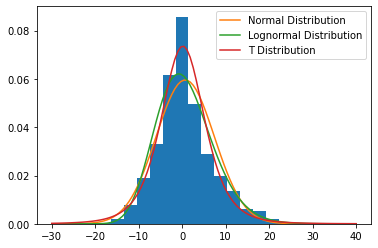

In [3]:
#Test Distributional fits to data
pos = "RB"
dist = distfit()
distribution_data = udfs_data.loc[udfs_data["Pos"] == pos]["error"]
dist.fit_transform(distribution_data)
dist_norm = distfit(distr=['norm'])
dist_log = distfit(distr=['lognorm'])
dist_t = distfit(distr=['t'])
results_norm = dist_norm.fit_transform(distribution_data)
results_log = dist_log.fit_transform(distribution_data)
results_t = dist_t.fit_transform(distribution_data)

#Plot distributions against histogram
plt.hist(distribution_data, 20, density=True)
pdf_x = np.linspace(-30, 40, num=100)
norm_pdf_y = stats.norm.pdf(pdf_x, results_norm["model"]["loc"], results_norm["model"]["scale"])
log_pdf_y = stats.lognorm.pdf(pdf_x, results_log["model"]["params"][0], results_log["model"]["loc"], results_log["model"]["scale"])
t_pdf_y = stats.t.pdf(pdf_x, results_t["model"]["params"][0], results_t["model"]["loc"], results_t["model"]["scale"])

plt.plot(pdf_x, norm_pdf_y, label = "Normal Distribution")
plt.plot(pdf_x, log_pdf_y, label = "Lognormal Distribution")
plt.plot(pdf_x, t_pdf_y, label = "T Distribution")
plt.legend(["Normal Distribution", "Lognormal Distribution", "T Distribution"])

### Exploring error correlation

P-norm yncertainty sets also assume the data are uncorrelated. The first two cells in this section generate pairs of errors by position on the same team. The next two cells generates pairs of errors by position for players on opposing teams. The cells print out correlations and visuals of the data. It's clear that errors are correlated. For QB's and WR's on the same team, errors have a 0.27 correlation. For opposing defenses, errors have a correlation of -0.31. Feel free to try other pairs of positions to see their correlations.

Given these correlations, work needed to be done to account for this in the p-norm. This is the subject of the data whitening portion in the paper.

In [4]:
#Generate data for same team correlation analysis
err_pairs = []
dk_data2 = udfs_data
pos1 = "QB"
pos2 = "WR"

for year in dk_data2["Year"].unique():
    for week in dk_data2["Week"].unique():
        for team in dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week)]["Team"].unique():
            err1_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team"] == team) & (dk_data2["Pos"] == pos1)]
            err2_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team"] == team) & (dk_data2["Pos"] == pos2)]
            for error1 in err1_data["error"]:
                for error2 in err2_data["error"]:
                    err_pairs.append((error1, error2))

[[60.57559863 15.00851471]
 [15.00851471 49.31383523]]
[[1.         0.27460249]
 [0.27460249 1.        ]]


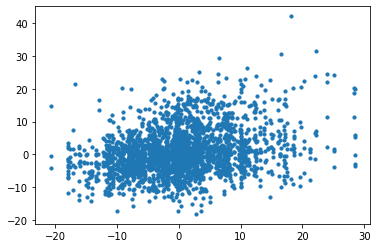

In [5]:
#Variance-Covariance and correlation
x = [err[0] for err in err_pairs]
y = [err[1] for err in err_pairs]
plt.scatter(x,y, s=10)
print(np.cov(x, y))
print(np.corrcoef(x,y))

In [6]:
#Generate data for opposite team correlation analysis
err_pairs = []
pos = "DST"
oppt_pos = "DST"

for year in dk_data2["Year"].unique():
    for week in dk_data2["Week"].unique():
        for team in dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week)]["Team2"].unique():
            err1_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team2"] == team) & (dk_data2["Pos"] == pos)]
            try: 
                err2_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team2"] == err1_data["Oppt"].iloc[0]) & (dk_data2["Pos"] == oppt_pos)]
            except:
                print("Year: " + str(year) + "; Week: " + str(week) + "; Team: " + team)
            for error1 in err1_data["error"]:
                for error2 in err2_data["error"]:
                    err_pairs.append((error1, error2))


[[ 32.25557073 -10.19517366]
 [-10.19517366  32.78616263]]
[[ 1.        -0.3135068]
 [-0.3135068  1.       ]]


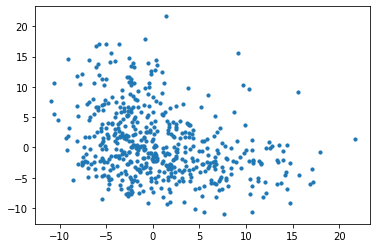

In [7]:
#Variance-Covariance and correlation
x = [err[0] for err in err_pairs]
y = [err[1] for err in err_pairs]
plt.scatter(x,y, s=10)
print(np.cov(x, y))
print(np.corrcoef(x,y))

### Early visuals of uncertainty sets

As seen from the previous section, the errors are correlated so the standard p-norm set is not valid. However, we can account for them using data whitening as described by the data whitening portion of the paper. The following section overlays a box, ball, and polygon uncertainty set over generated set of data. To be clear, this is not done using data whitening and p-norm sets. That is somewhat convoluted to do in matplotlib. Proper uncertainty sets should look like the green shapes below for box and polygon uncertainty sets.

![alt text](https://github.com/drmbeledogu/RobustDFS/raw/main/Documents/uncertainty_sets.png)

These visuals which are also in the paper were generated using [desmos graphing calculator](https://www.desmos.com/calculator). Feel free to toy around in desmos to generate more accurate visuals. The visuals output by the cells below are just to get a rough idea of how well the shapes cover the data before jumping into the true robust formulation.

(array([22.32224187, 42.71949149]), array([[-0.71624469,  0.69784923],
       [-0.69784923, -0.71624469]]))


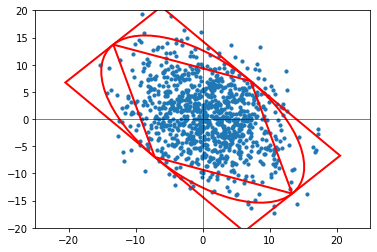

In [11]:
#Generate random data using measured mean and covariance
mean = [np.mean(x), np.mean(y)]
cov = np.cov(x, y)
rand_data = stats.multivariate_normal.rvs(mean, cov, 1000)

#Helper function for rotating points around the origin
def rotate(x, y, angle_rad):
    x_rot = x*math.cos(angle_rad) - y*math.sin(angle_rad)
    y_rot = y*math.cos(angle_rad) + x*math.sin(angle_rad)
    return [x_rot, y_rot]

#Extract rotation and scaling from covariance matrix using eigenvalues and eigenvectors 
transform = np.linalg.eig(cov)
rot = transform[1]
angle_rad = math.atan(rot[1, 0]/rot[0, 0])
angle = math.degrees(math.atan(rot[1, 0]/rot[0, 0]))
print(transform)

#Points for plotting shapes
width = 20
height = width*(transform[0][1]/transform[0][0])
poly_points = [rotate(width/2, 0, angle_rad), rotate(0, -height/2, angle_rad), rotate(-width/2, 0, angle_rad), rotate(0, height/2, angle_rad)]
rect_anc = rotate(-width/2, -height/2, angle_rad)

#Plotting data and shapes
fig, ax = plt.subplots()
ax.scatter(rand_data[:, 0], rand_data[:, 1], s=10)
ax.add_patch(Rectangle((rect_anc[0], rect_anc[1]), width, height, angle, edgecolor="red", fill=False, lw=2))
ax.add_patch(Ellipse((0, 0), width, height, angle, edgecolor="red", fill=False, lw=2))
ax.add_patch(Polygon(poly_points, edgecolor="red", fill=False, lw=2))
ax.axhline(color='black', lw=0.5)
ax.axvline(color='black', lw=0.5)
ax.set_xlim(-25, 25)
ax.set_ylim(-20, 20)
plt.show()